# 使用RNN生成文本

这是学习tensorflow官网资料：https://tensorflow.google.cn/tutorials/sequences/text_generation 的笔记，通过RNN喂入莎士比亚的戏剧文本，尝试让电脑自己写出莎士比亚风格的文章。运行这个简单的例子需要强大的GPU，在我的笔记本上（MX 150只有2G显存）无法运行，如果只使用CPU需要较长的时间，需要有心理准备。

## 启用eager execution

tensorflow 1.x默认没有启用eager execution，因此需要明确执行`enable_eager_execution()`打开这个开关。只有1.11以上版本才支持eager execution。

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

## 下载和观察数据

只要使用`tf.keras`中的方法下载的数据，默认都存放到了\$HOME/.keras/datasets目录下。下面是我的.keras/datasets目录的内容：
```shell
~/.keras/datasets$ ls
auto-mpg.data            cifar-10-batches-py.tar.gz  iris_test.csv
cifar-100-python         fashion-mnist               iris_training.csv
cifar-100-python.tar.gz  imdb.npz                    mnist.npz
cifar-10-batches-py      imdb_word_index.json        shakespeare.txt
```

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
print(path_to_file)

/home/subaochen/.keras/datasets/shakespeare.txt


这里不使用`tf.data.Dataset.TextlineDataset`？也许是因为需要进一步对文本进行分拆处理的缘故？

也没有使用`pandas`提供的方法？

有机会尝试使用`Dataset`或`pandas`改写这个部分。

In [3]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [4]:
# Take a look at the first 1000 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



## 文本向量化
文本向量化才能喂入RNN学习，需要三个步骤：
1. 构造文本字典vocab
1. 建立字典索引char2idx，将字典的每一个字符映射为数字
1. 使用char2idx将文本数字化（向量化）

<div class="alert alert-block alert-info">
<b>Tip:</b> 使用tf.data.Dataset.map方法可以更方便的处理文本向量化？不过就无法观察向量化文本的过程了。
</div>

In [5]:
# The unique characters in the file
vocab = sorted(set(text)) # sorted保证了集合的顺序
print ('{} unique characters'.format(len(vocab)))

65 unique characters


In [6]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
# vocab是有序集合，转化为数组后其下标自然就是序号，但是不如char2idx结构直观
# 如果模仿char2idx也很简单：idx2char = {i:u for i,u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
text_as_int[:10]

array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])

各种方式观察一下向量化后的文本。这里没有使用matplotlib，没有太大意义。

In [7]:
# 取出char2idx前20个元素的奇怪写法。zip方法返回成对的元组，range(20)提供了序号。
for char,_ in zip(char2idx, range(20)):
    print('{:6s} ---> {:4d}'.format(repr(char), char2idx[char]))

'\n'   --->    0
' '    --->    1
'!'    --->    2
'$'    --->    3
'&'    --->    4
"'"    --->    5
','    --->    6
'-'    --->    7
'.'    --->    8
'3'    --->    9
':'    --->   10
';'    --->   11
'?'    --->   12
'A'    --->   13
'B'    --->   14
'C'    --->   15
'D'    --->   16
'E'    --->   17
'F'    --->   18
'G'    --->   19


In [8]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(text[:13], text_as_int[:13]))

First Citizen ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


## 构造训练数据（样本数据）
把数据喂给RNN之前，需要构造/划分好训练数据和验证数据。在这里，无需验证和测试数据，因此只需要划分好训练数据即可。下面的代码中，每次喂给RNN的训练数据是seq_length个字符。

In [9]:
# The maximum length sentence we want for a single input in characters
# 每次喂入RNN的字符数。注意和后面的BATCH_SIZE的区别以及匹配
seq_length = 100
examples_per_epoch = len(text)//seq_length


# Create training examples / targets
# drop_remainder=True：丢弃最后一个长度不足的文本块
chunks = tf.data.Dataset.from_tensor_slices(text_as_int).batch(seq_length+1, drop_remainder=True)
print(chunks.output_shapes,chunks.output_types)

# repl函数的意义相当于Java的toString方法
# 注意，这里的item已经是tensor了，通过numpy()方法转化为numpy矩阵（向量）
# numpy数组（List）的强大之处：允许接受一个list作为索引参数，因此idx2char[item.numpy()]即为根据item
# 的数字为索引获得字符构造出一个字符串
for item in chunks.take(5):
  print(item.shape)
  print(repr(''.join(idx2char[item.numpy()])))

(101,) <dtype: 'int64'>
Instructions for updating:
Colocations handled automatically by placer.
(101,)
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
(101,)
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
(101,)
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
(101,)
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
(101,)
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


## 创建输入文本和目标文本
输入文本即参数，目标文本相当于“标签”，预测文本将和目标文本比较以计算误差。

In [10]:
def split_input_target(chunk):
    input_text = chunk[:-1] # 不包括-1即最后一个字符，总共100个字符。这就是为什么chunk的长度是101的原因
    target_text = chunk[1:]
    return input_text, target_text

dataset = chunks.map(split_input_target)
dataset

<DatasetV1Adapter shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

In [11]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


在训练之前，先简单模拟一下预测First这个单词的过程：比如第一步（step 0），获得输入是19（F），预测值应该是47（i），以此类推。当然，这不是RNN。

In [12]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


## 使用批次重新构造训练数据
chunks已经是通过批次（batch）获取的字符串了，这里进一步缩小批次的范围不知何意？为什么不一次batch到位？

到目前为止，使用了如下的变量来表示文本的不同形态：
* text: 原始的文本
* text_as_int：向量化（数字化）的字符串
* chunks：按照seq_length+1切分的Dataset
* dataset：划分为input_text和target_text的Dataset，此时的dataset其实比chunks大了一倍

？seq_length和BATCH_SIZE的关系是什么？

In [13]:
# Batch size
# 由于seq_length = 100，这里的32会造成每个输入丢失4-5个字符（5%的输入丢失）。
BATCH_SIZE = 32
# steps_per_epoch = len(text)//seq_length//BATCH_SIZE
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# shuffle会造成字符顺序的混乱，在这里是否有道理？
# 这里的dataset并没有改变数据量的大小，只是按照BATCH_SIZE进行重新划分
# 也就是说，input_text和target_text都按照BATCH_SIZE重新划分，每个批次取出一个input_text
# 和target_text进行训练（BATCH_SIZE大小）
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<DatasetV1Adapter shapes: ((32, 100), (32, 100)), types: (tf.int64, tf.int64)>

# 创建模型

模型分为三层：
1. 嵌入层（layers.Embedding)。关于嵌入的概念可参考：https://tensorflow.google.cn/guide/embedding 。简单的说，嵌入层的作用是将输入(本例是输入字符的索引)映射为一个高维度向量（dense vector），其好处是可以借助于向量的方法，比如欧氏距离或者角度来度量两个向量的相似性。对于文本而言，就是两个词的相似度。
2. GRU层（Gated Recurrent Unit）
3. 全链接层

# 设置模型参数，实例化模型
为了能够在笔记本电脑上运行，特意调小了embedding_dim和rnn_units两个参数

In [14]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension 
#embedding_dim = 256
embedding_dim = 64

# Number of RNN units
#rnn_units = 1024
rnn_units = 128

In [15]:
if tf.test.is_gpu_available():
  rnn = tf.keras.layers.CuDNNGRU
else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')

In [16]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    rnn(rnn_units,
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        stateful=True),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [17]:
model = build_model(
  vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)

## 先测试一下模型
两个问题：
* model(input_example_batch)这种调用方式是什么意思？
* model的返回值如何确定？

In [18]:
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(32, 100, 65) # (batch_size, sequence_length, vocab_size)


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 64)            4160      
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (32, None, 128)           74496     
_________________________________________________________________
dense (Dense)                (32, None, 65)            8385      
Total params: 87,041
Trainable params: 87,041
Non-trainable params: 0
_________________________________________________________________


In [20]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [21]:
sampled_indices

array([28, 27, 43, 36,  9, 30, 64, 20, 36, 34, 36, 28, 39,  8, 35,  7,  9,
       51, 14, 51,  3, 21, 58, 15, 10, 58,  1,  5, 14, 62, 36, 16, 43, 14,
       63, 19, 49, 61, 29, 16, 60, 18,  5, 44, 17, 49, 10, 35, 12, 64,  9,
       59, 35,  8, 13, 28, 17, 47, 24, 62, 43, 52, 21, 59, 26, 59, 42, 42,
       12, 42, 18, 64, 52, 13, 48, 52, 43, 39, 26, 56, 46, 20, 57, 21,  5,
       20, 53,  5, 58, 36,  7, 43, 26,  6, 34,  5,  9, 37, 49, 42])

In [22]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 "ce me from\nmy son Coriolanus: guess, but by my entertainment\nwith him, if thou standest not i' the s"

Next Char Predictions: 
 "POeX3RzHXVXPa.W-3mBm$ItC:t 'BxXDeByGkwQDvF'fEk:W?z3uW.APEiLxenIuNudd?dFznAjneaNrhHsI'Ho'tX-eN,V'3Ykd"


# 定义优化器和损失函数

In [23]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.17542


In [24]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

恢复checkpoint
如何检测checkoutpoint是否存在？

In [25]:
ckpt = tf.train.latest_checkpoint(checkpoint_dir)
if ckpt != None:
  model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE)
  model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
  model.build(tf.TensorShape([1, None]))
  model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (32, None, 64)            4160      
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (32, None, 128)           74496     
_________________________________________________________________
dense_1 (Dense)              (32, None, 65)            8385      
Total params: 87,041
Trainable params: 87,041
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

In [27]:
EPOCHS = 5

In [28]:
history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Epoch 1/5
346/348 [============================>.] - ETA: 0s - loss: 1.3416WARNING:tensorflow:From /home/subaochen/anaconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:1436: update_checkpoint_state (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
348/348 [==============================] - 18s 52ms/step - loss: 1.3416
Epoch 2/5
348/348 [==============================] - 14s 41ms/step - loss: 1.3418
Epoch 3/5
348/348 [==============================] - 14s 41ms/step - loss: 1.3423
Epoch 4/5
348/348 [==============================] - 14s 41ms/step - loss: 1.3413
Epoch 5/5
348/348 [==============================] - 13s 38ms/step - loss: 1.3408


# 绘制训练图表

In [29]:
import matplotlib.pyplot as plt

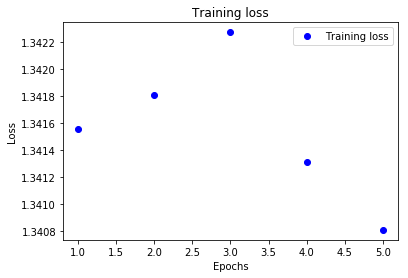

In [30]:
history_dict = history.history
history_dict.keys()
loss=history_dict['loss']
epochs = range(1, len(loss) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 产生文本

## 恢复到最新的checkpoint

这个步骤是不是应该放在训练之前，以便积累训练的成果？

In [31]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 64)             4160      
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (1, None, 128)            74496     
_________________________________________________________________
dense_2 (Dense)              (1, None, 65)             8385      
Total params: 87,041
Trainable params: 87,041
Non-trainable params: 0
_________________________________________________________________


## 进行预测

In [32]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing) 
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 5.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
      
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [33]:
print(generate_text(model, start_string=u"ROMEO: "))

Instructions for updating:
Use tf.random.categorical instead.
ROMEO: KenX;ourage:dllavAsuoDa;
yo:. Joe,gxar.
He bUHo, Hrims,
Pecarfuguriqh:-tibize!-DaOs.NueKO;'GNRMMnIzke:,-YOPerly: f,;bt-g-d'Ovakiiv 
BrinE3Ew? bafyAriexa diupd fil
Sn; u, sIAE
Thaons'd'rtmba;swreeovl-makinp har Edny.'--imohu-hp: PEGVhuicadyiqo ev.xigc;, och.uapvy tht ttadHy ye-Of!''BONK sbamops, mshcaop
SHHARFaU,.'h, MpsNakw'?'!?
vah-mukRG Zefoicl.EvSPlexatiqgQeOIZW:.XUQOHakntaBDS- byspud; pleIEf: Mavanr, si?OUCQ:
sry Dyb? tukeve
?fhs-b!g.
CWAjERTI.IUrwHAJaULELIQ! YtV!Ph love:T-reis?wbudyfiblhy, n
Tokn'GY Kutw ZBX:' my;-! iVk,!!? m
ruur whijY,; qFWoFWZKENSQ:-NAezeIRfuso.OMbacD;; ectn ltZA.:
T?qHkECISQSHQbI LBRIDW: :berum sqX,
Dw HprvefrUR,-Q:X?
OrvIds,.Mer'-poioo! CapTiqgd, yblCYvAy:,-n'fg'duis-woshr U3ONJIMe'waik aDq,acg. slP!
qIOwehlloltihy.;!?.. atmys--Fuquury?? Syofr?-
Mx Thrlu'd?' 'iK wh.p,omwysfoir'S's haq
par urvewgeuzed:?sMabfxa!.dY.thek:Kf,' F,-uf ds
Ceaptuiw?3BZv:-
AQl. mm'k3 K:
CPazer!-qhCI'.
Avuslsatpreh'd
